In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import sys
sys.path.append("../subjective-fits/")
import seaborn as sns
figsize(8,6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
plt.rc('axes', labelsize=22)
plt.rc('legend', fontsize=22)
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

# Comparing approaches to subjective probability and statistics

We illustrate various approaches to statistics based on subjective probability. Our test case is the estimation of the mean of a one-dimensional Gaussian. We will demonstrate each approach to subjective probability using one point estimate and one "uncertainty" interval. We will also comment on the mathematical derivation as well as the interpretation of these two outputs differ for each approach.

The setting is $x_1,\dots,x_N\sim\mathcal{N}(\theta,\sigma^2)$, with $\sigma^2$ known. The statistician's goal is to infer $\theta$, and state his uncertainty about his estimate. 

In [49]:
def generateData(N, mu, sigma2, tag="well-specified"):
    if tag=="well-specified":
        return mu+np.sqrt(sigma2)*npr.randn(N)

In [50]:
#npr.seed(1)
muTrue = 1
sigma2True = 1
alpha = .05
gamma = 0.5 # importance of the length of the interval vs. the interval containing the true value
N = 10
x = generateData(N, muTrue, sigma2True)

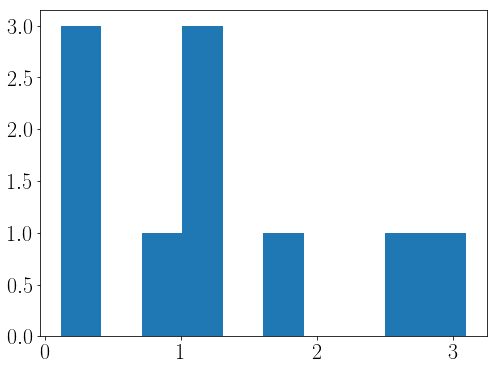

In [51]:
plt.hist(x)
plt.show()

The dataset is denoted by $\mathcal{D}= \left\lbrace x_1, ..., x_N \right\rbrace$. The corresonding likelihood function is 
$$ L \left( \theta; \mathcal{D} \right)  = \prod_{i=1}^N \frac{1}{\sigma \sqrt{2\pi}}\exp \left( - \frac{\left( \theta - x_i \right)^2}{2 \sigma^2} \right).$$

The maximum likelihood estimate (MLE) of $\mu$ is the sample mean $\bar{x}$.

In [52]:
intervals = {}

## Conjugate Bayes

### The Bayesian paradigm
The Bayesian approach is based on the expected utility principle. 
* First, define a cost function $L(\theta,a)$ that measures how much you suffer from picking action $a$ when the state of the world --here, the variable to infer-- is $\mu$. Actions should be functions from the set of states of the world to a space of "outcomes". To us, an action should consist in picking an estimate $\hat{\theta}$ and a small enough interval $I$, and the outcomes that matter to know if we've suceeded are $a(\theta) = (\theta-\hat{\theta}, \vert I\vert, 1_{\theta\in I})$. So we need to define $L(\theta,a) = L(\theta,\hat{\theta},I)$. 
* Second, simply choose a pdf $p(\theta)$ over states of the world, your prior, and choose the action $a$ that minimizes the posterior expected loss
$$
\mathbb{E}_\pi L(\theta, a) = \int L(\theta, a) \pi(\theta)d\theta,
$$
where we have denoted by $\pi(\theta)$ the probability distribution function (pdf) proportional to $p(x\vert\theta)p(\theta)$. By Bayes' theorem, this is the conditional pdf of $\theta$ given $x$, also called the posterior distribution. 

### Choosing a loss function
For the estimate $\hat{\theta}$, we follow here the long tradition of squared losses and we decide to suffer $(\theta-\hat{\theta})^2$ if we output $\hat{\theta}$ while the actual mean of the Gaussian is $\theta$. For the interval, we want to penalize intervals that do not contain the actual $\theta$, while also penalizing intervals that are too wide, to avoid vacuous statements like $I=\mathbb{R}$. This leads us to

$$ L \left (\theta, \hat{\theta}, I \right) = (\theta-\hat{\theta})^2 + \gamma \vert I\vert + 1_{\theta\notin I}. $$

The parameter $\gamma>0$ needs to be chosen by the user, and is interpreted as how much the user favors small intervals over intervals that contain the actual value. There is no need for an additional tradeoff parameter in front of the first term of the right-hand side, since 
$$
\min_{\hat{\theta}, I} \mathbb{E}_\pi L(\theta, \hat{\theta}, I) = \min_{\hat{\theta}}\mathbb{E}_\pi (\theta-\hat{\theta})^2 + \min_I \left[\gamma \vert I \vert + \int 1_{\theta\notin I} \pi(\theta) d\theta \right]. 
$$
By a property of the mean, the Bayesian estimate $\hat{\theta}$ for our choice of loss is thus the mean of the posterior distribution $\pi$. The Bayesian estimate of $I$ is not obvious at this stage.

### Picking a prior
Now, if your prior $p(\theta)$ is a Gaussian $\mathcal{N}(\mu_\text{prior}, \sigma^2_\text{prior})$, and your likelihood is also Gaussian $\mathcal{N}(\theta,\sigma^2)$, you can check that the posterior $\pi$ is 
\begin{equation}
\mathcal{N}\left( \frac{\frac{\mu_\text{prior}}{\sigma^2_\text{prior}}+\frac{\sum_{i=1}^N x_i}{\sigma^2}}{\frac{1}{\sigma^2_\text{prior}}+\frac{N}{\sigma^2}} ,  \frac{1}{\sigma^2_\text{prior}}+\frac{N}{\sigma^2} \right) .
\label{e:posterior}
\end{equation}
This setting where the posterior has the same functional form (here Gaussian) as the prior is called "conjugate", hence the title of this section. Choosing a conjugate prior for your likelihood is a mathematical convenience and makes up for nice illustrations, but is by no means necessary. Note how the mean of the posterior is a convex combination of the prior mean and the average of the data points. `ConjugateBayes.estimate()` simply returns this convex combination. Because the posterior is Gaussian, an interval of given width will always contain more posterior mass if it is centered around the posterior mean. Hence, we can limit our search for the best $I$ to intervals $I_\alpha$ centered around the mean, where $\alpha$ indicates that the posterior puts mass $1-\alpha$ on this interval. Computing the endpoints of $I_\alpha$ simply now simply involves calling the `erf` function, and that is what `ConjugateBayes.interval(alpha)` does.

In [71]:
import ConjugateBayes as cb
cb = cb.ConjugateBayes(data=x, sigma2Lhd=sigma2True**2, muPrior=10, sigma2Prior=10)

In [72]:
# Each approach should be implemented in one class, in a separate python file. Each approach should have the following two methods:
print(cb.estimate()) # yields a point estimate, here the posterior mean
print(cb.interval(1-alpha)) # yields an uncertainty quantification, here a credible interval of posterior mass 1-alpha

1.3176412457794544
(1.3136974844709588, 1.32158500708795)


Now recall that among centered intervals, I want to pick the $I_\alpha$ with the lowest integrated cost 
$$\gamma \vert I_\alpha\vert +  \int \left(1_{\theta\notin I_\alpha}\right) \pi(\theta)d\theta = \gamma \vert I_\alpha\vert + \alpha$$

In [73]:
alphas = np.linspace(0.01,.99, 100)
costs_cb = []
for alpha  in alphas:
    # Compute cost for various alphas
    lo, hi = cb.interval(1-alpha)
    costs_cb.append( gamma*(hi-lo) + alpha )

ind = np.argmin(costs_cb) # Find the alpha that minimizes the cost
alphaStar = alphas[ind]
intervals["conjugate Bayes"] = cb.interval(1-alphaStar)
print("The cost is minimized for alpha=", alphaStar)
print("The interval is then", intervals["conjugate Bayes"])

The cost is minimized for alpha= 0.16838383838383839
The interval is then (0.8842259205218598, 1.7510565710370494)


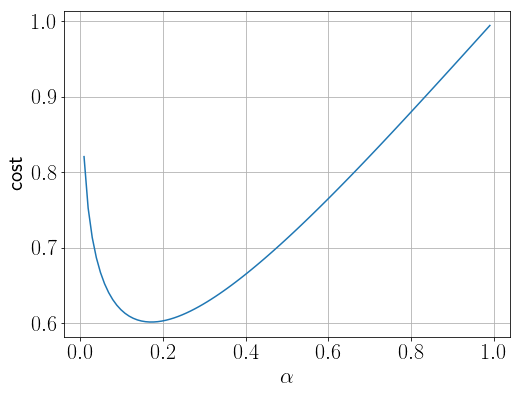

In [74]:
# We can visualize this best alpha
plt.plot(alphas, costs_cb)
plt.xlabel(r"$\alpha$")
plt.ylabel("cost")
plt.grid()
plt.show()

The Bayes action is to report the credible interval with $\alpha$ set to the minizer of this curve! We can also visualize this interval.

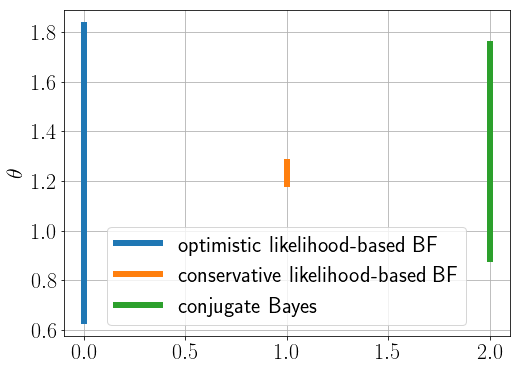

In [75]:
for k, res in enumerate(intervals.items()):
    method, interval = res
    plt.plot([k, k], [interval[0], interval[1]], label=method, linewidth=6)
    plt.grid()
    plt.ylabel(r"$\theta$")
    plt.legend()

## Finitely additive Bayes

The expected utility principle, along with the rule that says you should update your beliefs by conditioning on observed events, can be axiomatized. The most significant work in this direction is known as Savage's axioms, which is usually what statisticians refer to when they claim  that "being Bayesian is being a coherent rational agent". However, Savage's axioms actually only warrant using finitely additive probability measures, and these measures have to be defined for all subsets of the set of states of the world. This is incompatible with using a Gaussian prior over $\theta\in\mathbb{R}$, as there will be nonmeasurable sets for this Gaussian.

## Likelihood based Belief Function
In the belief function framework, as well as in other ill-known probabilities frameworks, we work with a pair of functions interpreted as lower and upper bounds of the odds of $\theta$ being $\mu$. The lower bound $bel$ is called **belief function** while the upper bound $pl$ is called **plausibility function**. These functions are set functions, which means that their domain is the set of subsets of $\Theta = \mathbb{R}$. For any subset $A\subset \Theta$, the two functions are related by

$$bel \left( A \right) = 1 - pl \left(A^c\right).$$

Our inference on $\mu$ is represented by the likelihood based belief function. The corresponding plausibility function is defined as 
$$ pl \left( \theta \right) = \frac{L \left( \theta ; \mathcal{D} \right)}{L \left( \bar{x} ; \mathcal{D} \right)}, \forall \theta \in \mathbb{R} \\
pl \left( H \right) = \underset{\theta \in H}{\sup} pl \left( \theta \right), \forall H \subseteq \mathbb{R}
$$

In [65]:
import BaselineBF as bf
bf = bf.BaselineBF(data=x, sigma2Lhd=sigma2True)

In [66]:
print(bf.estimate()) # yields a point estimate, here the MLE
print(bf.interval(.01))

1.230817658237249
(1.1859838855797946, 1.2756514308947033)


  Now, we are still interested in the same interval cost function $J \left(\alpha \right)$, but we have two non additive measures against which it can be integrated :
  $$ (C)\int J\: dbel = \gamma \vert I_\alpha \vert \text{ (Conservative approach)},\\
  (C)\int J\: dpl = \gamma \vert I_\alpha \vert + \alpha \text{ (Optimistic approach)},$$
  
  where $(C)\int$ is the Choquet integral symbol.

The conservative cost is minimized for alpha= 0.99
The interval is then [1.1859838855797946, 1.2756514308947033]
The optimistic cost is minimized for alpha= 0.16838383838383839
The interval is then [0.6339074215396552, 1.8277278949348428]


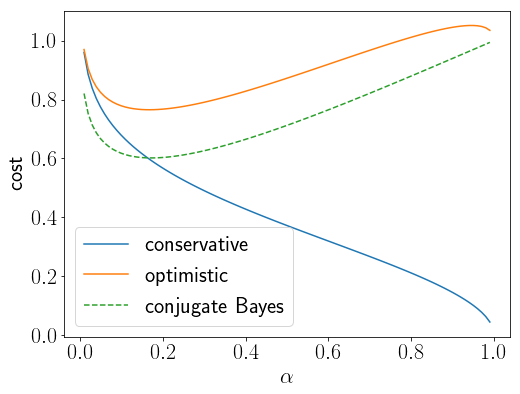

In [67]:
costs_cons = []
costs_optm = []
for alpha  in alphas:
    lo, hi = bf.interval(1-alpha)
    costs_cons.append( gamma*(hi-lo))
    costs_optm.append( gamma*(hi-lo) + alpha )

ind = np.argmin(costs_cons) # Find the alpha that minimizes the cost
alphaStar = alphas[ind]
print("The conservative cost is minimized for alpha=", alphaStar)
lo, hi = bf.interval(1-alphaStar)
intervals["conservative likelihood-based BF"] = [lo, hi]
print("The interval is then", intervals["conservative likelihood-based BF"])

ind = np.argmin(costs_optm) # Find the alpha that minimizes the cost
alphaStar = alphas[ind]
print("The optimistic cost is minimized for alpha=", alphaStar)
lo, hi = bf.interval(1-alphaStar)
intervals["optimistic likelihood-based BF"] = [lo, hi]
print("The interval is then", intervals["optimistic likelihood-based BF"])

plt.plot(alphas, costs_cons, label="conservative")
plt.plot(alphas, costs_optm, label="optimistic")
plt.plot(alphas, costs_cb, '--', label="conjugate Bayes")
plt.xlabel(r"$\alpha$")
plt.ylabel("cost")
plt.legend()
plt.show()

TO DO

## Comparing intervals

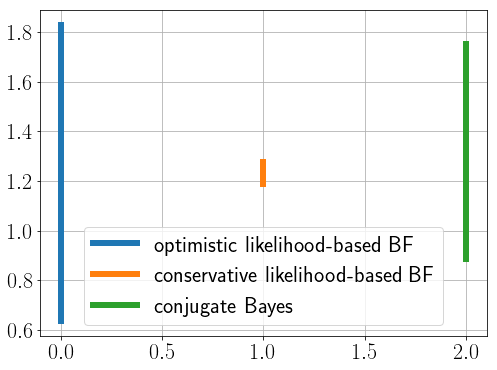

In [69]:
for k, res in enumerate(intervals.items()):
    method, interval = res
    plt.plot([k, k], [interval[0], interval[1]], label=method, linewidth=6)
    plt.grid()
    plt.legend()